In [1]:
import re

import networkx as nx

from IPython.display import Image, display
from collections import defaultdict, Counter
from textblob import TextBlob
from itertools import combinations
from tqdm import tqdm

from litecoder.db import City

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('seaborn-muted')

In [3]:
def tokenize(text):
    return [str(t) for t in TextBlob(text).tokens]

In [6]:
def keyify(text):
    text = text.lower()
    text = re.sub('[^a-z0-9]', '', text)
    return text

In [64]:
class Token:
    
    def __init__(self, token, ignore_case=True, scrub_re='\.'):
        
        self.ignore_case = ignore_case
        self.scrub_re = scrub_re
        
        self.token = token
        self.token_clean = self._clean(token)
        
    def _clean(self, token):
        
        if self.ignore_case:
            token = token.lower()
            
        if self.scrub_re:
            token = re.sub(self.scrub_re, '', token)
            
        return token
    
    def __call__(self, input_token):
        return self._clean(input_token) == self.token_clean
    
    def __repr__(self):
        return '%s<%s>' % (self.__class__.__name__, self.token_clean)
    
    def __hash__(self):
        # TODO: Class identifier?
        return hash((self.token_clean, self.ignore_case, self.scrub_re))
    
    def __eq__(self, other):
        return hash(self) == hash(other)
    
    def label(self):
        return '<%s>' % self.token_clean

In [117]:
class GeoFSA(nx.MultiDiGraph):
    
    def __init__(self):
        """Set table + id, root node.
        """
        super().__init__()
        self.start_node = self.next_node()
        
    def add_node(self, node):
        super().add_node(node, final=set())
        
    def next_node(self):
        """Get next integer node id, counting up.
        """
        node = max(self.nodes) + 1 if self.nodes else 0
        self.add_node(node)
        
        return node
        
    def add_token(self, accept_fn, entity, parent=None, optional=False):
        """Register a token transition.
        """
        s1 = parent if parent else self.start_node
        s2 = self.next_node()
        
        self.add_edge(
            s1, s2,
            accept_fn=accept_fn,
            entities=set([entity,]),
            label=accept_fn.label(),
        )
        
        last_node = s2
        
        # Add skip links if optional.
        if optional:
            s3 = self.next_node()
            self.add_edge(s2, s3, label='ε')
            self.add_edge(s1, s3, label='ε')
            last_node = s3
        
        return last_node
    
    def set_final(self, state, entity):
        self.node[state]['final'].add(entity)
        
    def outer_nodes(self):
        return [n for n in self.nodes() if self.out_degree(n)==0]
    
    def _merge_outer_pair(self, u, v):
        """Merge two leaf nodes.
        """
        # Add v finals -> u finals.
        self.node[u]['final'].update(g.node[v]['final'])
        
        # Redirect v edges -> u.
        for s, t, data in g.in_edges(v, data=True):
            g.add_edge(s, u, **data)
            
        self.remove_node(v)

In [118]:
def plot(g):
    dot = nx.drawing.nx_pydot.to_pydot(g)
    dot.set_rankdir('LR')
    display(Image(dot.create_png()))

In [121]:
g = GeoFSA()

for city in City.query.filter(City.country_iso=='US').limit(10):
    
    entity = (City.__tablename__, city.wof_id)
    
    name_tokens = tokenize(city.name)
    state_tokens = tokenize(city.name_a1)
    
    # City name
    parent = None
    for token in name_tokens:
        parent = g.add_token(Token(token), entity, parent)
        
    # Optional comma
    comma = g.add_token(Token(','), entity, parent, optional=True)
    
    # State name
    parent = comma
    for token in state_tokens:
        parent = g.add_token(Token(token), entity, parent)

    g.set_final(parent, entity)
        
    # Or, state abbr
    leaf = g.add_token(Token(city.us_state_abbr), entity, comma)
    g.set_final(leaf, entity)
    
print(len(g.nodes))

53


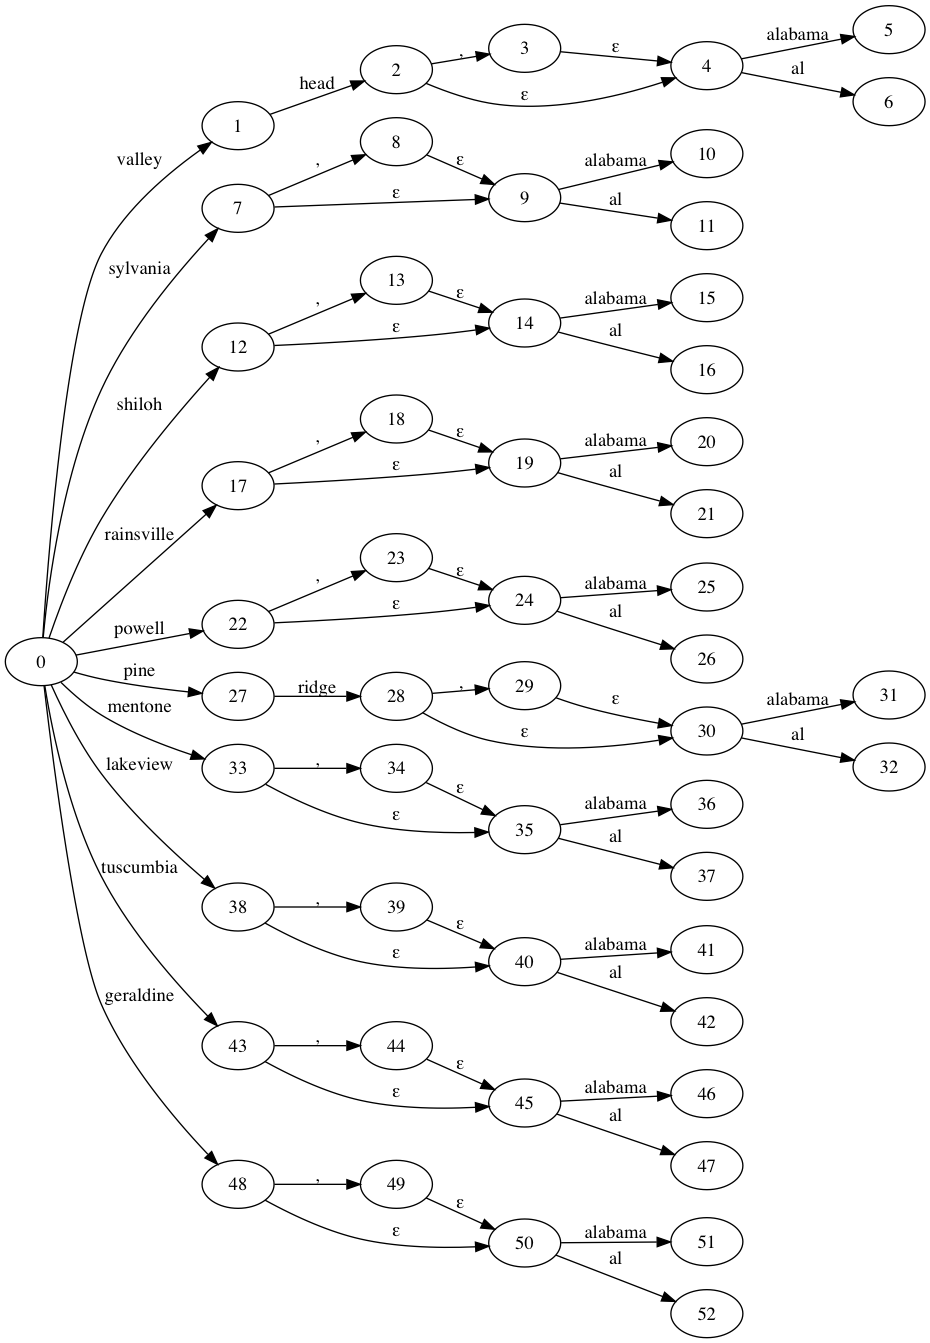

In [122]:
plot(g)

In [115]:
g._merge_outer_pair(46, 51)

KeyError: 46

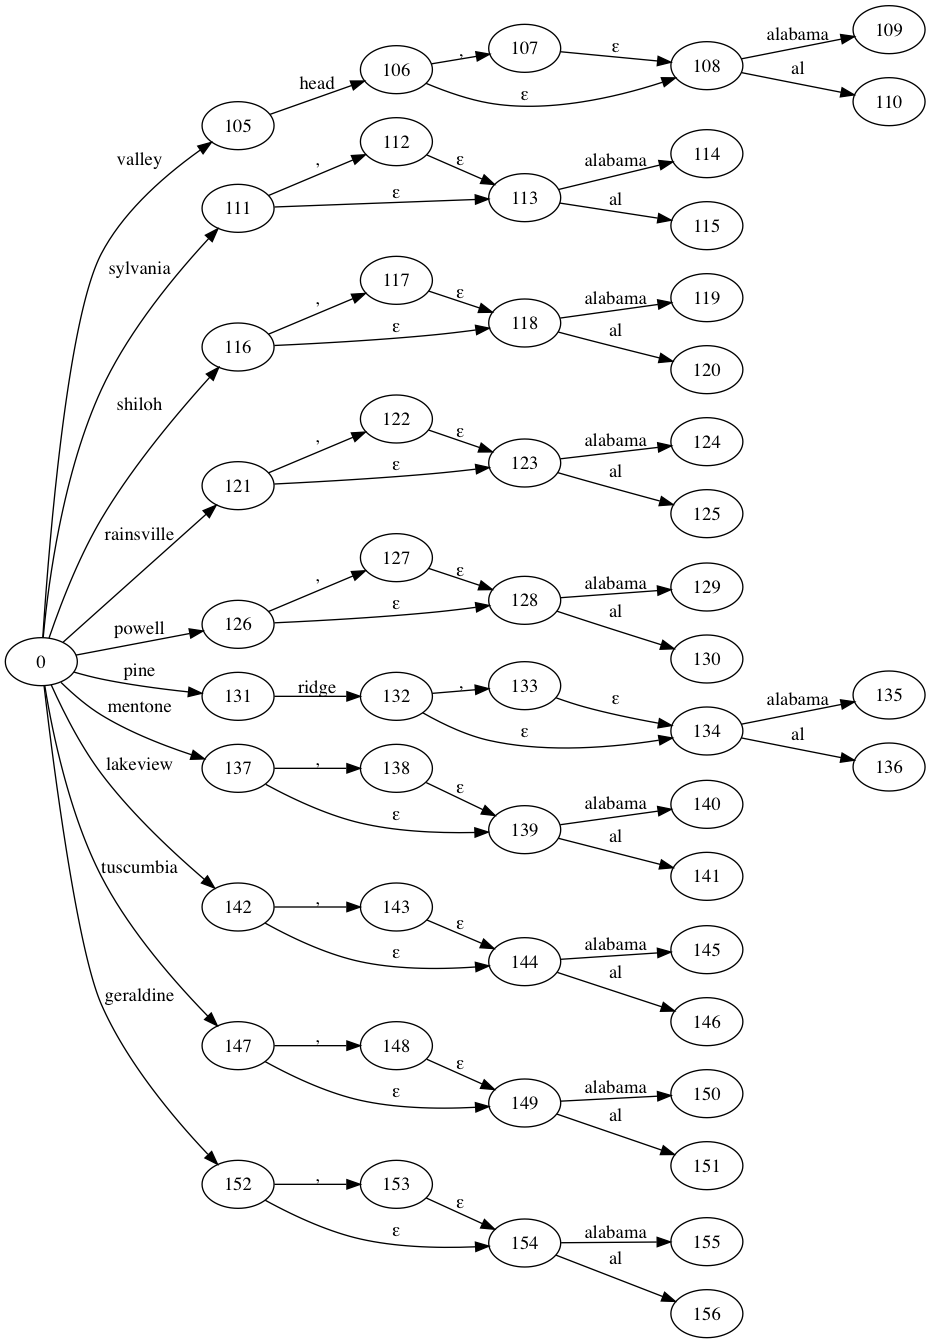

In [116]:
plot(g)

In [84]:
g.node[98]

{'final': {('city', 85897447), ('city', 85897453)}}

In [85]:
g[102][98]

AtlasView({0: {'accept_fn': Token<alabama>, 'entities': {('city', 85897453)}, 'label': '<alabama>'}})